# TO-DOs

+ Init lda to NMF. Sufficient to manage to install this modified version of lda package, needed for init lda to NMF:
```!pip install --upgrade git+git://github.com/llaurabat91/lda.git``` (currently not working) (C)
+ Add pLSA (C)
+ averaging word embeddings from Word2Vec SkipGram (C)
+ averaging word embeddings from GloVe (C)
+ tfidf-weighted word embeddings from Word2Vec SkipGram (L)
+ tfidf-weighted word embeddings from GloVe (L)
+ Check d2v is solid (very low similarities, maybe bug?) (L)
+ Prettify all plots (L)
+ Add hyperparams set-up to an overleaf (C)

In [1]:
# Install necessary packages
# !pip install gdown
# !pip install --upgrade gensim

In [2]:
#!pip install lda

In [3]:
# Restart RUNTIME after installing packages!

In [1]:
import pandas as pd
import numpy as np
import gdown
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from itertools import product, combinations_with_replacement
import lda
import pickle

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy import linalg
from sklearn.decomposition import NMF
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import itertools

import sys
sys.path.append('../pymodules')

In [3]:
# run if interested in the Additional section

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 118)
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.width', 10000)

In [4]:
# define paths and seed
seed = 92
data_path = "./"

In [5]:
# define dictionary with paths to data in Google Drive
data_url_dict = {"10K_vocab_2019_min25": ("https://drive.google.com/uc?id=1va-ob3C7UD0pYV4Z6WEhL2WMP7ynQJCH", "csv"),
                "10K_dtmatrix_2019_min25": ("https://drive.google.com/uc?id=1c-lNSgaj3tKjnkpn_12ddCL3OP6IsXLT", "txt"),
                "10K_raw_text_2019_min25": ("https://drive.google.com/uc?id=1T97btZK10417MNXGlx_ASFY0mzqpNtu9", "csv"),
                "w2v_sg_min25": ("https://drive.google.com/uc?id=1JpP3oxpZ1Dr5vTyutwIKIUoknsa418YF", "sav"),
                "glove_min25": ("https://drive.google.com/uc?id=1hmXKSrmRV2P6wr7C20s7fAhKUy3gp7SO", "sav"),
                "tic_cik_crosswalk": ("https://drive.google.com/uc?id=1YsbeWapKf_hvfP3qMo9-Xj-PFuH5R96o", "csv")}

In [10]:
# download each file in the dictionary (it takes a while)
for file_name, attributes in data_url_dict.items():
    url = attributes[0]
    extension = attributes[1]
    gdown.download(url, f"{file_name}.{extension}", quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1va-ob3C7UD0pYV4Z6WEhL2WMP7ynQJCH
To: /home/cmarangon/Dropbox/RA_work/ARE_text/text_algorithms_econ/notebooks/10K_vocab_2019_min25.csv
100%|██████████| 422k/422k [00:00<00:00, 1.72MB/s]
Downloading...
From: https://drive.google.com/uc?id=1c-lNSgaj3tKjnkpn_12ddCL3OP6IsXLT
To: /home/cmarangon/Dropbox/RA_work/ARE_text/text_algorithms_econ/notebooks/10K_dtmatrix_2019_min25.txt
100%|██████████| 310M/310M [02:53<00:00, 1.79MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1T97btZK10417MNXGlx_ASFY0mzqpNtu9
To: /home/cmarangon/Dropbox/RA_work/ARE_text/text_algorithms_econ/notebooks/10K_raw_text_2019_min25.csv
100%|██████████| 1.34G/1.34G [11:31<00:00, 1.94MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JpP3oxpZ1Dr5vTyutwIKIUoknsa418YF
To: /home/cmarangon/Dropbox/RA_work/ARE_text/text_algorithms_econ/notebooks/w2v_sg_min25.sav
100%|██████████| 108M/108M [00:56<00:00, 1.92MB/s] 
Downloading...
From: https://drive.google.com/

# 1. Load data

This tutorial uses text data from the **10-K reports** filed by most publicly-traded firms in the U.S. in 2019. 10-K reports are a very rich source of data since firms include information regarding their organizational structure, financial performance and risk factors. We will use a version of the data where the risk factors section of each report has been splitted into sentences and each sentence has been assigned an ID that combines the firm identifier (i.e. **CIK**) and a sentence number. The data we use has a total of 1,077,416 sentences for 2,500 firms.

More on the 10-K reports [here](https://www.investor.gov/introduction-investing/getting-started/researching-investments/how-read-10-k).

In [6]:
raw_data = pd.read_csv(data_path + '10K_raw_text_2019_min25.csv', index_col='Unnamed: 0')

In [7]:
dt_mat = pd.read_csv(data_path + '10K_dtmatrix_2019_min25.txt', index_col='Unnamed: 0')
dt_vals = dt_mat.values

In [8]:
dt_mat.shape

(4033, 19170)

In [9]:
vocab_df = pd.read_csv(data_path + '10K_vocab_2019_min25.csv', index_col='Unnamed: 0', keep_default_na=False)

In [10]:
vocab = vocab_df.to_dict()['0']

In [11]:
tics = pd.read_csv(data_path+'tic_cik_crosswalk.csv') #3196
raw_data.cik.isin(tics.cik).sum()

3196

In [12]:
# alternative ticker datasets (even fewer matches)

# tickers = pd.read_csv('../../cik_ticker.csv', sep='|') #2684
# tickers2 = pd.read_csv('../../ticker_2.txt', sep='\t', header=None, names=['ticker', 'cik']) #3183

In [13]:
df = raw_data.merge(tics, on='cik', how='left').copy()

# Documents as frequency vectors: an illustration

In [18]:
names_cosine =  ['AAPL', 'GOOGL', 'KO', 'PEP', 'DAL', 'LUV', 'CALM', 'BALL', 'BUKS']
idxs_cosine = np.array(df[df.tic.isin(names_cosine)].index)
cosine_dict = {k:v for k,v in zip(names_cosine, idxs_cosine)}

In [19]:
cosine_similarities = {f'{k1}_{k2}':cosine_similarity(dt_vals[cosine_dict[k1]].reshape(1, -1), 
                                                      dt_vals[cosine_dict[k2]].reshape(1, -1))[0][0] 
                       for k1, k2 in list(combinations_with_replacement(names_cosine, 2))
                      if k1!=k2}
cosine_similarities = {k: v for k, v in sorted(cosine_similarities.items(), key=lambda item: item[1])}

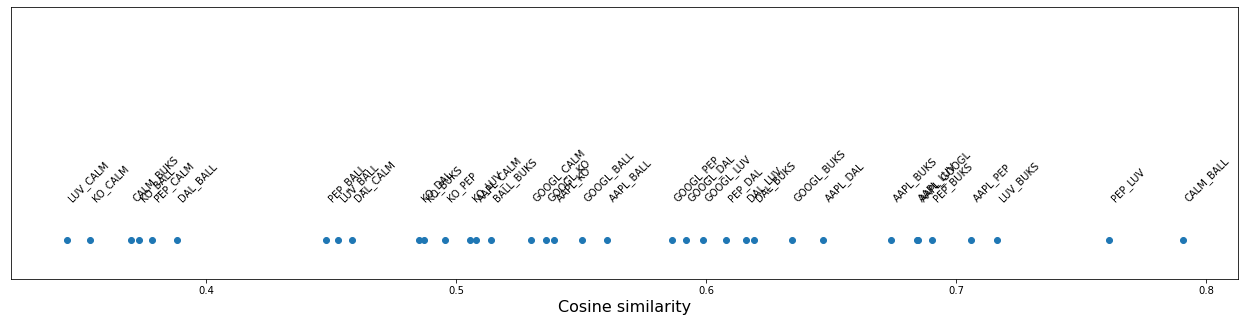

In [20]:
fig, ax = plt.subplots(figsize=(22,5))

k = len(cosine_similarities)
sims = list(cosine_similarities.values())
names = list(cosine_similarities.keys())

ax.scatter(sims, np.zeros((k,)) )
for i in range(k):
    ax.annotate(names[i], (sims[i], 0+0.005), rotation=45)
ax.set_ylim(bottom=-0.005, top=0.03)
ax.set_xlabel('Cosine similarity', fontsize=16)
ax.set_yticks([])    
plt.show()

In [21]:
companies =  ['AAPL', 'GOOGL', 'KO', 'PEP', 'DAL', 'LUV']
temp = df[df.tic.isin(companies)]
idxs_comps = np.array(temp.index).astype(int)
names_comps = temp.tic.values

In [22]:
target_dict = {'customer':4394, 'airline':1172, 'environment':5876, 'price':12951, 'product':13154,
               'outsourcing':11949}
terms = list(target_dict.keys())
ixs_terms = np.array(list(target_dict.values())).astype(int)

In [23]:
heatmap_df = pd.DataFrame(dt_vals[idxs_comps][:,ixs_terms], columns=terms, index=names_comps)
heatmap_df

,customer,airline,environment,price,product,outsourcing
KO,1.0,0.0,0.0,1.0,0.0,0.0
DAL,0.0,0.0,0.0,0.0,0.0,0.0
PEP,2.0,0.0,0.0,0.0,2.0,0.0
LUV,0.0,0.0,0.0,0.0,1.0,0.0
AAPL,0.0,0.0,0.0,1.0,0.0,0.0
GOOGL,1.0,0.0,0.0,0.0,0.0,0.0


In [24]:
heatmap_df_rel = heatmap_df/heatmap_df.sum(0)

In [25]:
heatmap_df_rel

,customer,airline,environment,price,product,outsourcing
KO,0.25,NaN,NaN,0.5,0.000000,NaN
DAL,0.00,NaN,NaN,0.0,0.000000,NaN
PEP,0.50,NaN,NaN,0.0,0.666667,NaN
LUV,0.00,NaN,NaN,0.0,0.333333,NaN
AAPL,0.00,NaN,NaN,0.5,0.000000,NaN
GOOGL,0.25,NaN,NaN,0.0,0.000000,NaN


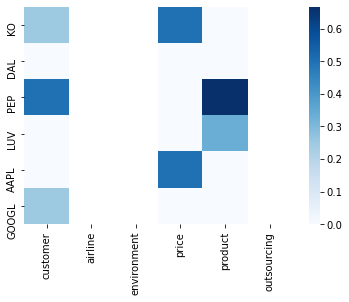

In [26]:
sns.heatmap(heatmap_df_rel, cmap='Blues')#, annot=heatmap_df)
plt.show()

In [27]:
# alternative visualization (not very insightful)
# fig, ax = plt.subplots()

# ax.scatter(x=heatmap_df['price'], y=heatmap_df['product'])
# ax.set_xlabel('price', fontsize=12)
# ax.set_ylabel('product', fontsize=12)

# names = ['AAPL', 'GOOGL', 'KO', 'PEP', 'DAL', 'LUV']
# for i in range(len(heatmap_df['price'])):
#     plt.annotate(names[i], (heatmap_df['price'][i]+0.2, heatmap_df['product'][i] + 0.6))

# plt.show()

# Estimate models

In [13]:
# %%
# Get BoW and set K
X = dt_vals
K = 20

In [14]:
# %%
# few seconds
# TFIDF
tfidf =TfidfTransformer(norm=u'l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
X_tfidf =tfidf.fit_transform(X)

X_tfidf = np.asarray(X_tfidf.todense())

In [15]:
# %%
np.save(data_path + 'X_tfidf.npy', X_tfidf)

In [16]:
%%time
# %%
# 8 min
# LSA
U, D, Vt = linalg.svd(X)
print(U.shape,  D.shape, Vt.shape)

Vt_r = Vt[:K]
print(Vt_r.shape)

X_LSA = X@Vt_r.T
print(X_LSA.shape)
# %%

(4033, 4033) (4033,) (19170, 19170)
(20, 19170)
(4033, 20)
CPU times: user 19min 57s, sys: 1min 47s, total: 21min 44s
Wall time: 2min 55s


In [17]:
np.save(data_path + 'X_LSA.npy', X_LSA)

In [18]:
%%time
# %%

#pLSA

##TODO

CPU times: user 12 µs, sys: 1e+03 ns, total: 13 µs
Wall time: 22.9 µs


In [19]:
%%time
# %%
# 10min
# NMF

NMFmodel = NMF(n_components=K, init='random', random_state=0,
max_iter=800)
X_NMF = NMFmodel.fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


CPU times: user 42min 45s, sys: 7min 9s, total: 49min 55s
Wall time: 6min 30s


In [20]:
# %%
np.save(data_path + 'X_NMF.npy', X_NMF)

In [21]:
%%time
# 30min
# LDA
X = X.astype('int64')
lda_model = lda.LDA(n_topics=K, n_iter=1500, random_state=1)
X_lda =  lda_model.fit_transform(X) 

INFO:lda:n_documents: 4033
INFO:lda:vocab_size: 19170
INFO:lda:n_words: 21106436
INFO:lda:n_topics: 20
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -229521156
INFO:lda:<10> log likelihood: -207281904
INFO:lda:<20> log likelihood: -190764175
INFO:lda:<30> log likelihood: -186705341
INFO:lda:<40> log likelihood: -184928180
INFO:lda:<50> log likelihood: -183909253
INFO:lda:<60> log likelihood: -183200480
INFO:lda:<70> log likelihood: -182688752
INFO:lda:<80> log likelihood: -182278255
INFO:lda:<90> log likelihood: -181941225
INFO:lda:<100> log likelihood: -181659732
INFO:lda:<110> log likelihood: -181402751
INFO:lda:<120> log likelihood: -181179602
INFO:lda:<130> log likelihood: -180991300
INFO:lda:<140> log likelihood: -180809146
INFO:lda:<150> log likelihood: -180639129
INFO:lda:<160> log likelihood: -180499691
INFO:lda:<170> log likelihood: -180357674
INFO:lda:<180> log likelihood: -180238839
INFO:lda:<190> log likelihood: -180129824
INFO:lda:<200> log likelihood: -180005382
INFO

CPU times: user 1h 26min 17s, sys: 1.48 s, total: 1h 26min 18s
Wall time: 1h 26min 20s


In [22]:
#%%
np.save(data_path + 'X_lda.npy', X_lda)
#%%
# X_lda = np.load(save_path + 'X_lda.npy')
#%%

In [23]:
%%time
# doc-to-vec
# 9 min
# tag documents
tagged_data = [TaggedDocument(words=doc, 
tags=[str(i)]) for i, doc in enumerate(df.tokens_25.values)]

#%%
d2v_model = Doc2Vec(tagged_data, vector_size=700, 
window=5, min_count=1, workers=4)
#%%
d2v_model.save(data_path + "d2v.model")

INFO:gensim.models.doc2vec:collecting all words and their counts
INFO:gensim.models.doc2vec:PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
INFO:gensim.models.doc2vec:collected 46 word types and 4033 unique tags from a corpus of 4033 examples and 287491774 words
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 46 unique words (100.00% of original 46, drops 0)', 'datetime': '2022-07-14T20:46:23.609780', 'gensim': '4.2.0', 'python': '3.8.10 (default, Mar 15 2022, 12:22:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-121-generic-x86_64-with-glibc2.29', 'event': 'prepare_vocab'}
INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 287491774 word corpus (100.00% of original 287491774, drops 0)', 'datetime': '2022-07-14T20:46:23.693190', 'gensim': '4.2.0', 'python': '3.8.10 (default, Mar 15 2022, 12:22:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-121-ge

INFO:gensim.models.word2vec:EPOCH 0 - PROGRESS: at 82.79% examples, 467032 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 0 - PROGRESS: at 83.93% examples, 466280 words/s, in_qsize 8, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 0 - PROGRESS: at 85.15% examples, 465981 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 0 - PROGRESS: at 86.29% examples, 465275 words/s, in_qsize 6, out_qsize 3
INFO:gensim.models.word2vec:EPOCH 0 - PROGRESS: at 87.63% examples, 465191 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 0 - PROGRESS: at 88.89% examples, 464669 words/s, in_qsize 8, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 0 - PROGRESS: at 90.11% examples, 464283 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 0 - PROGRESS: at 91.37% examples, 463978 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 0 - PROGRESS: at 92.59% examples, 463621 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:

INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 83.54% examples, 439597 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 84.73% examples, 439547 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 85.92% examples, 439400 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 87.18% examples, 439541 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 88.45% examples, 439392 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 89.69% examples, 439496 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 90.88% examples, 439495 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 92.14% examples, 439377 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 93.28% examples, 439083 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:

INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 84.73% examples, 438789 words/s, in_qsize 8, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 85.92% examples, 438783 words/s, in_qsize 8, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 87.18% examples, 438810 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 88.45% examples, 438632 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 89.69% examples, 438770 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 90.90% examples, 438923 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 92.14% examples, 438899 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 93.33% examples, 438865 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 94.55% examples, 438849 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:

INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 85.64% examples, 437571 words/s, in_qsize 8, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 86.86% examples, 437461 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 88.17% examples, 437443 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 89.39% examples, 437474 words/s, in_qsize 8, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 90.63% examples, 437621 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 91.87% examples, 437660 words/s, in_qsize 8, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 93.06% examples, 437539 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 94.32% examples, 437609 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 95.56% examples, 437591 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:

INFO:gensim.models.word2vec:EPOCH 4 - PROGRESS: at 87.63% examples, 439057 words/s, in_qsize 4, out_qsize 3
INFO:gensim.models.word2vec:EPOCH 4 - PROGRESS: at 88.89% examples, 439083 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 4 - PROGRESS: at 90.08% examples, 439215 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 4 - PROGRESS: at 91.30% examples, 439152 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 4 - PROGRESS: at 92.41% examples, 438693 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 4 - PROGRESS: at 93.65% examples, 438757 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 4 - PROGRESS: at 94.94% examples, 439018 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 4 - PROGRESS: at 96.03% examples, 438555 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 4 - PROGRESS: at 97.15% examples, 438026 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:

INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 88.27% examples, 438249 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 89.51% examples, 438213 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 90.70% examples, 438252 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 91.87% examples, 437899 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 93.03% examples, 437940 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 94.25% examples, 437996 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 95.51% examples, 438179 words/s, in_qsize 8, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 96.70% examples, 438132 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 97.77% examples, 437760 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:

INFO:gensim.models.word2vec:EPOCH 6 - PROGRESS: at 89.49% examples, 438615 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 6 - PROGRESS: at 90.65% examples, 438390 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 6 - PROGRESS: at 91.87% examples, 438223 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 6 - PROGRESS: at 93.06% examples, 438324 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 6 - PROGRESS: at 94.25% examples, 438203 words/s, in_qsize 8, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 6 - PROGRESS: at 95.51% examples, 438370 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 6 - PROGRESS: at 96.70% examples, 438335 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 6 - PROGRESS: at 97.82% examples, 438079 words/s, in_qsize 8, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 6 - PROGRESS: at 98.93% examples, 437637 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:

INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 90.55% examples, 438906 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 91.77% examples, 438784 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 92.98% examples, 438909 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 94.20% examples, 438716 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 95.46% examples, 438590 words/s, in_qsize 7, out_qsize 3
INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 96.70% examples, 438808 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 97.82% examples, 438718 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 98.91% examples, 438358 words/s, in_qsize 8, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 7: training on 287491774 raw words (33332921 effective words) took 76.0s, 438570 effective words/s
INF

INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 91.37% examples, 437134 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 92.59% examples, 437142 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 93.78% examples, 437173 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 95.04% examples, 437278 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 96.18% examples, 437020 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 97.35% examples, 436889 words/s, in_qsize 8, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 98.46% examples, 436617 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 99.63% examples, 436488 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8: training on 287491774 raw words (33335212 effective words) took 76.3s, 436728 effective words/s
INF

INFO:gensim.models.word2vec:EPOCH 9 - PROGRESS: at 91.84% examples, 438127 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 9 - PROGRESS: at 93.03% examples, 438012 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 9 - PROGRESS: at 94.22% examples, 437898 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 9 - PROGRESS: at 95.49% examples, 438006 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 9 - PROGRESS: at 96.70% examples, 438119 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 9 - PROGRESS: at 97.82% examples, 437948 words/s, in_qsize 7, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 9 - PROGRESS: at 98.93% examples, 437396 words/s, in_qsize 4, out_qsize 3
INFO:gensim.models.word2vec:EPOCH 9: training on 287491774 raw words (33337992 effective words) took 76.2s, 437729 effective words/s
INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'training on 2874917740 raw words (333346157 effective words)

CPU times: user 49min 20s, sys: 2.17 s, total: 49min 22s
Wall time: 12min 56s


In [24]:
%%time
#%%
d2v_model= Doc2Vec.load(data_path + "d2v.model")

#%%
# list of sentences
# each sentence is a list of 700-dim words
X_d2v = np.array([d2v_model.dv[i] 
                        for i in range(df.shape[0])])

INFO:gensim.utils:loading Doc2Vec object from ./d2v.model
INFO:gensim.utils:loading dv recursively from ./d2v.model.dv.* with mmap=None
INFO:gensim.utils:loading wv recursively from ./d2v.model.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:Doc2Vec lifecycle event {'fname': './d2v.model', 'datetime': '2022-07-14T20:59:00.936621', 'gensim': '4.2.0', 'python': '3.8.10 (default, Mar 15 2022, 12:22:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-121-generic-x86_64-with-glibc2.29', 'event': 'loaded'}


CPU times: user 18.9 ms, sys: 3.78 ms, total: 22.7 ms
Wall time: 21.3 ms


In [25]:
#%%
np.save(data_path + 'X_d2v.npy', X_d2v)
# %%

In [26]:
# load w2v SG
from gensim.models import Word2Vec
w2v_sg = Word2Vec.load('w2v_sg_min25.sav')

INFO:gensim.utils:loading Word2Vec object from w2v_sg_min25.sav
INFO:gensim.utils:Word2Vec lifecycle event {'fname': 'w2v_sg_min25.sav', 'datetime': '2022-07-14T20:59:01.387230', 'gensim': '4.2.0', 'python': '3.8.10 (default, Mar 15 2022, 12:22:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-121-generic-x86_64-with-glibc2.29', 'event': 'loaded'}


In [27]:
%%time
# tfidf-weighted w2v SG
vocab_rev = {v:k for k,v in vocab.items()}

weighted_docs = []
for d_ix, doc in enumerate(X_tfidf):
    weighted_doc = []
    for w_ix, w_tfidf in enumerate(doc):
        weighted_emb = w_tfidf*w2v_sg.wv[vocab_rev[w_ix]] 
        weighted_doc += [weighted_emb]
    weighted_doc = np.array(weighted_doc).sum(0)
#     weighted_doc = np.array(weighted_doc).sum(0)/doc.sum()
    weighted_docs.append(weighted_doc)
X_tfidf_w2v_sg = np.array(weighted_docs)  
np.save(data_path + 'X_tfidf_w2v_sg.npy', X_tfidf_w2v_sg)

CPU times: user 7min 56s, sys: 293 ms, total: 7min 56s
Wall time: 7min 56s


In [28]:
%%time
# Averaging word-to-vec
#48 sec

#prepare sentences
sentences = [doc.split(' ') for doc in df['final_text_25']]

sentvecs = []
for sentence in sentences:
    vecs = [w2v_sg.wv[w] for w in sentence if w in w2v_sg.wv]
    if len(vecs)== 0:
        sentvecs.append(np.nan)
        continue
    sentvec = np.mean(vecs,axis=0)
    sentvecs.append(sentvec.reshape(1,-1))
#%%
# list of sentences
# each sentence is a list of 700-dim words

X_avgw2v = [doc[0] for doc in sentvecs]## check if same format of other output
np.save(data_path + 'X_avgw2v.npy', X_avgw2v)

CPU times: user 49.1 s, sys: 384 ms, total: 49.5 s
Wall time: 49.5 s


In [29]:
# load GloVe

with open(data_path + f'glove_min25.sav', 'rb') as fr:
    glove = pickle.load(fr)

In [30]:
%%time
# tfidf-weighted GloVe
vocab_rev = {v:k for k,v in vocab.items()}

weighted_docs = []
for d_ix, doc in enumerate(X_tfidf):
    weighted_doc = []
    for w_ix, w_tfidf in enumerate(doc):
        weighted_emb = w_tfidf*glove.word_vectors[glove.dictionary[vocab_rev[w_ix]]]
        weighted_doc += [weighted_emb]
    weighted_doc = np.array(weighted_doc).sum(0)
#     weighted_doc = np.array(weighted_doc).sum()/doc.sum()
    weighted_docs.append(weighted_doc)
X_tfidf_glove = np.array(weighted_docs) 
np.save(data_path + 'X_tfidf_glove.npy', X_tfidf_glove)

CPU times: user 7min 19s, sys: 2min 24s, total: 9min 44s
Wall time: 9min 44s


In [31]:
%%time
# Averaging Glove
#50 sec
 
#prepare sentences
sentences = [doc.split(' ') for doc in df['final_text_25']]

sentvecs = []
for sentence in sentences:
    vecs = [glove.word_vectors[glove.dictionary[w]] for w in sentence if w in glove.dictionary]
    if len(vecs)== 0:
        sentvecs.append(np.nan)
        continue
    sentvec = np.mean(vecs,axis=0)
    sentvecs.append(sentvec.reshape(1,-1))
#%%
# list of sentences
# each sentence is a list of 700-dim words

X_avglove = [doc[0] for doc in sentvecs]## check if same format of other output
np.save(data_path + 'X_avglove.npy', X_avglove)

CPU times: user 43.4 s, sys: 825 ms, total: 44.2 s
Wall time: 44.3 s


# Cosine similarity comparison

In [14]:
#%%
X_tfidf = np.load(data_path + 'X_tfidf.npy')
X_LSA = np.load(data_path + 'X_LSA.npy')
X_NMF = np.load(data_path + 'X_NMF.npy')
X_lda = np.load(data_path + 'X_lda.npy')
X_d2v = np.load(data_path + 'X_d2v.npy')
X_tfidf_w2v_sg = np.load(data_path + 'X_tfidf_w2v_sg.npy')
X_avgw2v = np.load(data_path + 'X_avgw2v.npy')
X_tfidf_glove = np.load(data_path + 'X_tfidf_glove.npy')
X_avglove = np.load(data_path + 'X_avglove.npy')

In [15]:
####### COSINE SIMILARITIES
# %%
sims_tfidf = cosine_similarity(X_tfidf)
sims_lsa = cosine_similarity(X_LSA)
sims_nmf = cosine_similarity(X_NMF)
sims_lda = cosine_similarity(X_lda)
sims_d2v = cosine_similarity(X_d2v)
sims_tfidf_w2v_sg = cosine_similarity(X_tfidf_w2v_sg)
sims_avgw2v = cosine_similarity(X_avgw2v)
sims_tfidf_glove = cosine_similarity(X_tfidf_glove)
sims_avglove = cosine_similarity(X_avglove)
#%%

In [16]:
flat_sims_tfidf = np.array(sims_tfidf[np.tril_indices(sims_tfidf.shape[0])])
flat_sims_lsa = np.array(sims_lsa[np.tril_indices(sims_lsa.shape[0])])
flat_sims_nmf = np.array(sims_nmf[np.tril_indices(sims_nmf.shape[0])])
flat_sims_lda = np.array(sims_lda[np.tril_indices(sims_lda.shape[0])])
flat_sims_d2v = np.array(sims_d2v[np.tril_indices(sims_d2v.shape[0])])
flat_sims_tfidf_w2v_sg = np.array(sims_tfidf_w2v_sg[np.tril_indices(sims_tfidf_w2v_sg.shape[0])])
flat_sims_avgw2v = np.array(sims_avgw2v[np.tril_indices(sims_avgw2v.shape[0])])
flat_sims_tfidf_glove = np.array(sims_tfidf_glove[np.tril_indices(sims_tfidf_glove.shape[0])])
flat_sims_avglove = np.array(sims_avglove[np.tril_indices(sims_avglove.shape[0])])
#%%

In [17]:
# run to have plots in LaTeX format

params = {
            'font.family': 'serif',
#           'font.serif': 'cmr10',
          'text.usetex': True,
        #   'text.latex.unicode': True,
          'axes.titlesize': 15,
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15,
          'font.weight': 'bold'}
plt.rcParams.update(params)

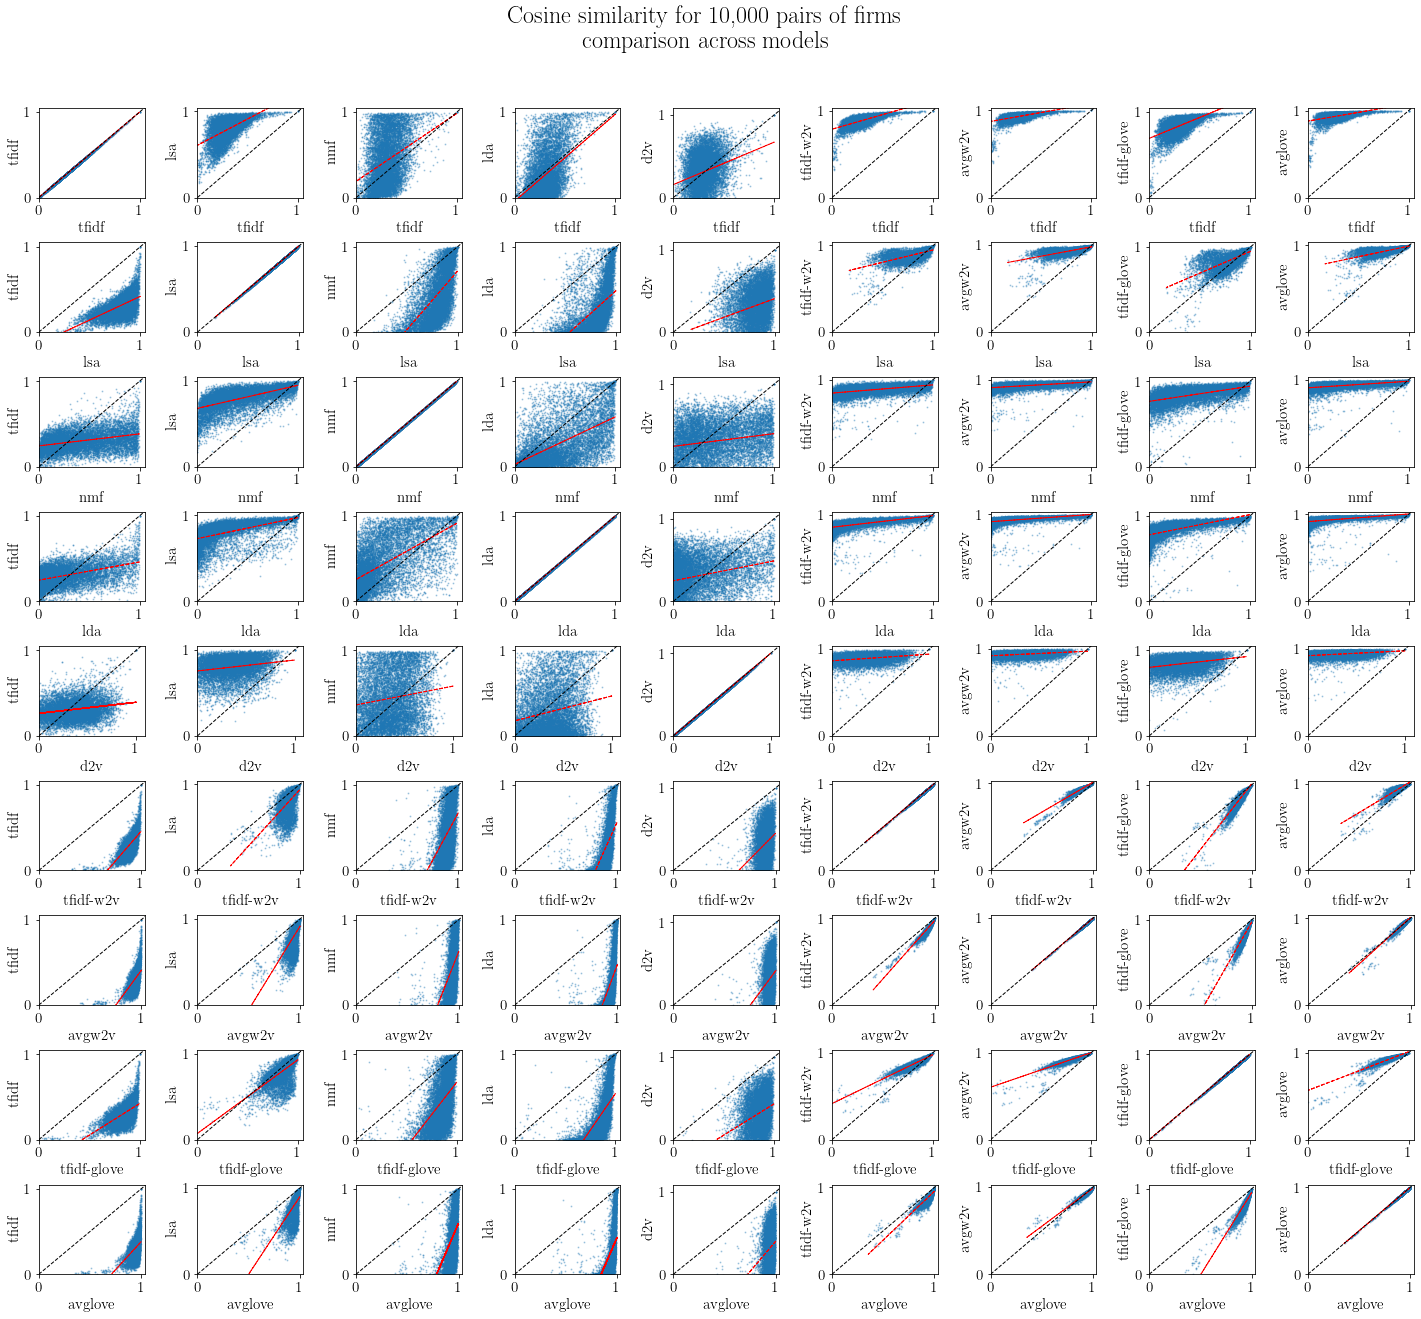

In [19]:
# l_range = 0
# u_range = 5000

# ticks = np.arange(l_range, u_range, 300)
# labs = np.array(np.tril_indices(sims_lsa.shape[0])).T
# labs = labs[ticks]

sample_range = np.linspace(0, flat_sims_tfidf.shape[0]-1,10000).astype(int)

#%%
fig, ax = plt.subplots(9,9, figsize=(20,20))
fig.suptitle('Cosine similarity for 10,000 pairs of firms \n comparison across models',
size=24)
sims_all = [flat_sims_tfidf, flat_sims_lsa, flat_sims_nmf, flat_sims_lda, 
            flat_sims_d2v, flat_sims_tfidf_w2v_sg, flat_sims_avgw2v,
            flat_sims_tfidf_glove, flat_sims_avglove]
names = ['tfidf', 'lsa', 'nmf', 'lda', 'd2v', 'tfidf-w2v', 'avgw2v',
         'tfidf-glove','avglove']

# scaler = StandardScaler()

for i in np.arange(9):
    for j in np.arange(9):
        x = sims_all[i][sample_range]
        y = sims_all[j][sample_range]

        # x = scaler.fit_transform(x.reshape(-1, 1) )
        # x = x.squeeze()
        # y = scaler.fit_transform(y.reshape(-1, 1) )
        # y = y.squeeze()

        ax[i][j].scatter(x,y, alpha=0.3, s=1)
        ax[i][j].set_ylim(bottom=0)
        ax[i][j].set_xlim(left=0)
        ax[i][j].set_xlabel(names[i])#, size=12)
        ax[i][j].set_ylabel(names[j])#, size=12)

        m, b = np.polyfit(x, y, 1)
        ax[i][j].plot(x, m*x + b, color='red', linewidth=1, linestyle='dashed')

        ax[i][j].plot(np.arange(0,3.05,0.05), np.arange(0,3.05,0.05), color='black', linewidth=1, linestyle='dashed')


plt.tight_layout()
plt.subplots_adjust(left=None, bottom=0.1, right=None, top=0.91, wspace=0.5, hspace=0.5)
plt.savefig('cosine_similarity_10000pairs.png')

plt.show()

# Ranking comparison

In [23]:
#%%
# extract 10,000 unique triplets of firms
n_samples = 10000
indices = np.arange(sims_lsa.shape[0])

In [24]:
triplet_idx = np.array([np.random.choice(indices, 3, replace=False) for i in range(n_samples)])
triplet_idx = np.sort(triplet_idx, axis=1)
triplet_idx = np.unique(triplet_idx, axis=0)
triplets = np.array([np.array([tr_idx[np.array([0,1])],
tr_idx[np.array([0,2])]]) for tr_idx in triplet_idx])

In [25]:
#%%
triplet_sims_tfidf = np.array([[sims_tfidf[tuple(tr[0])],
sims_tfidf[tuple(tr[1])]] for tr in triplets])
rankings_tfidf = np.array([1 if tr[0]>tr[1] else 0 
for tr in triplet_sims_tfidf])

In [26]:
#%%
triplet_sims_lsa = np.array([[sims_lsa[tuple(tr[0])],
sims_lsa[tuple(tr[1])]] for tr in triplets])
rankings_lsa = np.array([1 if tr[0]>tr[1] else 0 
for tr in triplet_sims_lsa])

In [27]:
#%%
triplet_sims_nmf = np.array([[sims_nmf[tuple(tr[0])],
sims_nmf[tuple(tr[1])]] for tr in triplets])
rankings_nmf = np.array([1 if tr[0]>tr[1] else 0 
for tr in triplet_sims_nmf])

In [28]:
#%%
triplet_sims_lda = np.array([[sims_lda[tuple(tr[0])],
sims_lda[tuple(tr[1])]] for tr in triplets])
rankings_lda = np.array([1 if tr[0]>tr[1] else 0 
for tr in triplet_sims_lda])

In [29]:
#%%
triplet_sims_d2v = np.array([[sims_d2v[tuple(tr[0])],
sims_d2v[tuple(tr[1])]] for tr in triplets])
rankings_d2v = np.array([1 if tr[0]>tr[1] else 0 
for tr in triplet_sims_d2v])

In [30]:
#%%
triplet_sims_tfidf_w2v_sg = np.array([[sims_tfidf_w2v_sg[tuple(tr[0])],
sims_tfidf_w2v_sg[tuple(tr[1])]] for tr in triplets])
rankings_tfidf_w2v_sg = np.array([1 if tr[0]>tr[1] else 0 
for tr in triplet_sims_tfidf_w2v_sg])

In [31]:
#%%
triplet_sims_avgw2v = np.array([[sims_avgw2v[tuple(tr[0])],
sims_avgw2v[tuple(tr[1])]] for tr in triplets])
rankings_avgw2v = np.array([1 if tr[0]>tr[1] else 0 
for tr in triplet_sims_avgw2v])

In [32]:
#%%
triplet_sims_tfidf_glove = np.array([[sims_tfidf_glove[tuple(tr[0])],
sims_tfidf_glove[tuple(tr[1])]] for tr in triplets])
rankings_tfidf_glove = np.array([1 if tr[0]>tr[1] else 0 
for tr in triplet_sims_tfidf_glove])

In [33]:
#%%
triplet_sims_avglove = np.array([[sims_avglove[tuple(tr[0])],
sims_avglove[tuple(tr[1])]] for tr in triplets])
rankings_avglove = np.array([1 if tr[0]>tr[1] else 0 
for tr in triplet_sims_avglove])

In [34]:
#%%
rankings = {'tfidf':rankings_tfidf, 
'lsa':rankings_lsa, 'nmf':rankings_nmf, 'lda':rankings_lda, 
            'd2v':rankings_d2v, 'tfidf-w2v': rankings_tfidf_w2v_sg, 'avgw2v': rankings_avgw2v,
             'tfidf-glove': rankings_tfidf_glove, 'avglove': rankings_avglove}

names = ['tfidf', 'lsa', 'nmf', 'lda', 'd2v', 'tfidf-w2v', 'avgw2v',
         'tfidf-glove','avglove']

#%%
fractions = {f'{a}_{b}': (rankings[a]==rankings[b]).sum()/n_samples
for a,b in list(itertools.combinations(names, 2))}

In [35]:
fractions

{'tfidf_lsa': 0.7279,
 'tfidf_nmf': 0.6339,
 'tfidf_lda': 0.6755,
 'tfidf_d2v': 0.5813,
 'tfidf_tfidf-w2v': 0.7734,
 'tfidf_avgw2v': 0.7486,
 'tfidf_tfidf-glove': 0.7359,
 'tfidf_avglove': 0.7201,
 'lsa_nmf': 0.7472,
 'lsa_lda': 0.7878,
 'lsa_d2v': 0.5876,
 'lsa_tfidf-w2v': 0.7879,
 'lsa_avgw2v': 0.8233,
 'lsa_tfidf-glove': 0.815,
 'lsa_avglove': 0.8412,
 'nmf_lda': 0.7346,
 'nmf_d2v': 0.5626,
 'nmf_tfidf-w2v': 0.6907,
 'nmf_avgw2v': 0.7093,
 'nmf_tfidf-glove': 0.7088,
 'nmf_avglove': 0.7232,
 'lda_d2v': 0.5872,
 'lda_tfidf-w2v': 0.7973,
 'lda_avgw2v': 0.8055,
 'lda_tfidf-glove': 0.8124,
 'lda_avglove': 0.8036,
 'd2v_tfidf-w2v': 0.5951,
 'd2v_avgw2v': 0.5969,
 'd2v_tfidf-glove': 0.601,
 'd2v_avglove': 0.5932,
 'tfidf-w2v_avgw2v': 0.928,
 'tfidf-w2v_tfidf-glove': 0.9071,
 'tfidf-w2v_avglove': 0.8723,
 'avgw2v_tfidf-glove': 0.9233,
 'avgw2v_avglove': 0.9277,
 'tfidf-glove_avglove': 0.9292}

In [36]:
fraction_mat = []
for n_ix, n in enumerate(names):
    row = []
    for m_ix, m in enumerate(names):
        frac = (rankings[n]==rankings[m]).sum()/n_samples
        row.append(frac)
    fraction_mat.append(np.array(row)) 
fraction_mat = np.array(fraction_mat)

In [37]:
fraction_df = pd.DataFrame(fraction_mat, index=names)
fraction_df.columns = names

In [38]:
# run to have plots in LaTeX format

params = {'font.family': 'serif',
          'text.usetex': True,
          'axes.titlesize': 15,
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15,
          'font.weight': 'bold'}
plt.rcParams.update(params)

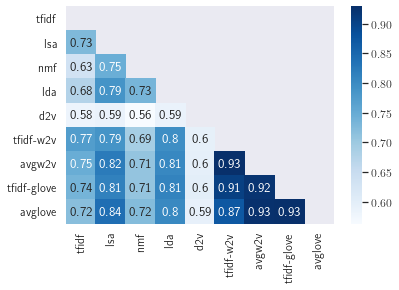

In [39]:
fig = plt.Figure(figsize=(19,19))
sns.set(font_scale=1.1)
sns.heatmap(fraction_df, cmap='Blues', annot=True, mask = np.triu(fraction_mat))
plt.savefig('fraction_heatmap.png')
plt.show()

# Additional: KNN analysis

In [86]:
# %%
def get_ranking(sims, target_ix, cols, similar=True, k=6):
    ranked_sents = df.iloc[(np.argsort(sims[target_ix])[::-1]),:]
    if similar:
        return ranked_sents.iloc[1:k+1][cols]
    else:
        return ranked_sents.iloc[-k:][cols]

#%%
def show_ranking_cik(sims_tfidf, sims_lsa, sims_nmf,sims_lda,
sims_d2v, target_ix, k=6, cols=['cik']):
    cols2 = ['index']

    # print(f'{k} most SIMILAR documents to "{np.array(df.cik.values)[target_ix]}"')
    print(f'{k} most SIMILAR documents to cik at index "{target_ix}"')

    tfidf_similar_sents = get_ranking(sims_tfidf, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)
    lsa_similar_sents = get_ranking(sims_lsa, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)
    nmf_similar_sents = get_ranking(sims_nmf, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)
    lda_similar_sents = get_ranking(sims_lda, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)   
    d2v_similar_sents = get_ranking(sims_d2v, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)

    sims_df = pd.concat([tfidf_similar_sents[cols2],lsa_similar_sents[cols2],
    nmf_similar_sents[cols2], lda_similar_sents[cols2], d2v_similar_sents[cols2]], axis=1)
    header = pd.MultiIndex.from_product([['-- TFIDF --','-- LSA --','-- NMF --','-- LDA --','-- d2v --'],
                                     ['index']])
    sims_df.columns = header
    display(sims_df)

    print(f'\n \n {k} most DISSIMILAR documents to cik at index "{target_ix}"')
    # print(f'\n \n {k} most DISSIMILAR documents to "{np.array(df.cik.values)[target_ix]}"')
    tfidf_diff_sents = get_ranking(sims_tfidf, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)
    lsa_diff_sents = get_ranking(sims_lsa, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)
    nmf_diff_sents = get_ranking(sims_nmf, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)
    lda_diff_sents = get_ranking(sims_lda, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)    
    d2v_diff_sents = get_ranking(sims_d2v, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)
    diff_df = pd.concat([tfidf_diff_sents[cols2],lsa_diff_sents[cols2],
    nmf_diff_sents[cols2], lda_diff_sents[cols2], d2v_diff_sents[cols2]], axis=1)
    diff_df.columns = header
    display(diff_df)

# %%
def show_similar_text(sims_tfidf, sims_lsa, sims_nmf,sims_lda,
sims_d2v, target_ix, k=2, cols=['clean_text_rest']):
    print(f'{k} most SIMILAR documents to "{np.array(df.clean_text_rest.values)[target_ix][:1000]}"')
    tfidf_similar_sents = get_ranking(sims_tfidf, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)
    lsa_similar_sents = get_ranking(sims_lsa, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)
    nmf_similar_sents = get_ranking(sims_nmf, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)
    lda_similar_sents = get_ranking(sims_lda, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)
    d2v_similar_sents = get_ranking(sims_d2v, target_ix, similar=True, k=k, cols=cols).reset_index(drop=False)

    sims_df_1 = pd.concat([tfidf_similar_sents,lsa_similar_sents,
    nmf_similar_sents], axis=1)
    header = pd.MultiIndex.from_product([['-- TFIDF --','-- LSA --','-- NMF --'],
                                     ['index','clean_text_rest']])
    sims_df_1.columns = header

    sims_df_2 = pd.concat([lda_similar_sents, d2v_similar_sents], axis=1)
    header = pd.MultiIndex.from_product([['-- LDA --','-- d2v --'],
                                     ['index', 'clean_text_rest']])
    sims_df_2.columns = header
    display(sims_df_1)
    display(sims_df_2)
# %%
def show_dissimilar_text(sims_tfidf, sims_lsa, sims_nmf,sims_lda,
sims_d2v, target_ix, k=2, cols=['clean_text_rest']):

    print(f'\n \n {k} most DISSIMILAR documents to "{np.array(df.clean_text_rest.values)[target_ix][:1000]}"')
    tfidf_diff_sents = get_ranking(sims_tfidf, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)
    lsa_diff_sents = get_ranking(sims_lsa, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)
    nmf_diff_sents = get_ranking(sims_nmf, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)
    lda_diff_sents = get_ranking(sims_lda, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)
    d2v_diff_sents = get_ranking(sims_d2v, target_ix, similar=False, k=k, cols=cols).reset_index(drop=False)

    diff_df_1 = pd.concat([tfidf_diff_sents,lsa_diff_sents,
    nmf_diff_sents], axis=1)
    header = pd.MultiIndex.from_product([['-- TFIDF --','-- LSA --','-- NMF --'],
                                    ['index', 'clean_text_rest']])
    diff_df_1.columns = header

    diff_df_2 = pd.concat([lda_diff_sents, d2v_diff_sents], axis=1)

    header = pd.MultiIndex.from_product([['-- LDA --','-- d2v --'],
                                    ['index', 'clean_text_rest']])
    diff_df_2.columns = header

    display(diff_df_1)
    display(diff_df_2)
# %%
#%%

In [87]:
# explore some examples
targets = [34, 48, 4]
k_neighbors = 5
#%%
for target in targets:
    print('=========================================================================================')
    show_ranking_cik(sims_tfidf=sims_tfidf, sims_lsa=sims_lsa, 
    sims_nmf=sims_nmf, sims_lda=sims_lda, 
                     sims_d2v=sims_d2v, 
    target_ix=target, k=k_neighbors, cols=['cik'])

5 most SIMILAR documents to cik at index "34"


,-- TFIDF --,-- LSA --,-- NMF --,-- LDA --,-- d2v --
,index,index,index,index,index
0,94,109,606,202,396
1,719,275,2026,109,275
2,380,316,474,902,269
3,44,202,526,136,81
4,851,166,2895,316,37



 
 5 most DISSIMILAR documents to cik at index "34"


,-- TFIDF --,-- LSA --,-- NMF --,-- LDA --,-- d2v --
,index,index,index,index,index
0,2725,845,3993,3855,3135
1,845,2725,1910,3927,2903
2,2620,2620,2063,4023,2833
3,2669,2669,3990,4025,3053
4,3115,3115,2144,3990,1850


5 most SIMILAR documents to cik at index "48"


,-- TFIDF --,-- LSA --,-- NMF --,-- LDA --,-- d2v --
,index,index,index,index,index
0,540,1071,18,346,3939
1,1325,540,1441,407,174
2,3271,332,1257,848,30
3,3384,114,1340,264,3987
4,3512,18,1721,1636,201



 
 5 most DISSIMILAR documents to cik at index "48"


,-- TFIDF --,-- LSA --,-- NMF --,-- LDA --,-- d2v --
,index,index,index,index,index
0,2620,1069,3993,3990,3246
1,3532,3115,2144,4025,2893
2,1850,3053,2952,4000,2518
3,3115,3532,3914,3829,3144
4,3053,1850,3990,3927,3053


5 most SIMILAR documents to cik at index "4"


,-- TFIDF --,-- LSA --,-- NMF --,-- LDA --,-- d2v --
,index,index,index,index,index
0,806,1934,3562,806,3842
1,1335,806,1084,1258,3959
2,363,3983,2565,1036,244
3,3651,611,720,390,76
4,2387,2021,1431,720,9



 
 5 most DISSIMILAR documents to cik at index "4"


,-- TFIDF --,-- LSA --,-- NMF --,-- LDA --,-- d2v --
,index,index,index,index,index
0,3532,2019,2063,3825,2498
1,3115,3246,2725,844,3144
2,2669,1069,845,3869,2601
3,2620,3053,2669,4025,1687
4,3053,3532,3990,3927,3053


In [88]:
#%%
k_neighbors = 2
for target in targets:
    print('=========================================================================================')
    show_similar_text(sims_tfidf=sims_tfidf, sims_lsa=sims_lsa, 
    sims_nmf=sims_nmf, sims_lda=sims_lda, 
                      sims_d2v=sims_d2v, 
    target_ix=target, k=k_neighbors, cols=['clean_text_rest'])

2 most SIMILAR documents to "the_company_ent face risk in the normal course_of_business_np and through global regional and local event that could have an adverse_impact_np on its reputation operation and financial_performance_np management direct a company-wide enterprise risk_management_np erm program with oversight from the_company_np board_of_directors_ent the_company_np audit_committee_ent have the delegate risk_management_np oversight responsibility and receive update on the risk_management_np process and key risk_factor_np on a quarterly_basis_np the_company_ent through its business_unit_np functional and corporate team continually update assess monitor and mitigate these and other_business_np and compliance_risk_np in accordance with the erm program and as monitor by the erm program team and chief risk officer the risk_factor_np that follow be the main risk that the erm program focus on to protect and enhance shareholder_value_np through intentional risk_mitigation_np plan base 

-- TFIDF --                                                    -- LSA --  \
        index                                    clean_text_rest     index   
0          94  item_1a_np risk factor the risk and uncertaint...       109   
1         719  the_company_np business result_of_operation_np...       275   

                                                     -- NMF --  \
                                     clean_text_rest     index   
0  some of the more significant_risk_factor_np re...       606   
1  provide below be a cautionary discussion of wh...      2026   

                                                      
                                     clean_text_rest  
0  the risk_factor_np list in this section and ot...  
1  kaanapali land face numerous_risk_np include t...

-- LDA --                                                    -- d2v --  \
      index                                    clean_text_rest     index   
0       202  the_company_np operation be subject to the gen...       396   
1       109  some of the more significant_risk_factor_np re...       275   

                                                      
                                     clean_text_rest  
0  as be the case for any retailer the_company_np...  
1  provide below be a cautionary discussion of wh...

2 most SIMILAR documents to "the follow be a description of the risk_factor_np that could because our actual_result_np to differ materially from those contain in forward-looking statement make in this annual report_on_form_np 10-k and present elsewhere by management_from_time_np to time such_factor_np may have a material_adverse_effect_np on our_business_np financial_condition_ent and result_of_operation_np and you should carefully consider they before decide to invest in or retain share of our common_stock_ent these risk_factor_np do not identify all risk that we face our_operation_np could also be affect by factor that be not presently know to we or that we currently consider to be immaterial to our_operation_np due to risk and uncertainty know and unknown our past financial_result_np may not be a reliable_indicator_np of future_performance_np and historical_trend_np should not be use to anticipate result or trend in future_period_np we compete with a large number_of_company_np in th

-- TFIDF --                                                    -- LSA --  \
        index                                    clean_text_rest     index   
0         540  investor should carefully consider the risk se...      1071   
1        1325  we wish to caution reader that the follow impo...       540   

                                                     -- NMF --  \
                                     clean_text_rest     index   
0  our inability to accurately forecast and estim...        18   
1  investor should carefully consider the risk se...      1441   

                                                      
                                     clean_text_rest  
0  the following discussion_of_risk_np factor sho...  
1  you should carefully consider the risk describ...

-- LDA --                                                    -- d2v --  \
      index                                    clean_text_rest     index   
0       346  our result_of_operation_np and revenue may flu...      3939   
1       407  an investment in the_company_np security invol...       174   

                                                      
                                     clean_text_rest  
0  invest in the_company_np common_stock_ent invo...  
1  an investment_in_our_np common_stock_ent be su...

2 most SIMILAR documents to "various portion of this report contain forward-looking statement that involve risk and uncertainty actual_result_np performance or achievement could differ materially from those anticipate in these forward-looking statement as a result of certain_risk_factor_np include those set forth below and elsewhere in this report we undertake no obligation to revise or update any forward-looking statement contain herein to reflect subsequent event or circumstance or the occurrence of unanticipated_event_np we depend on the success of our lmr product_line_np we currently depend on our lmr product as our sole_source_np of sale a decline in the price of and/or demand for lmr product as a result_of_competition_np technological_change_np the introduction of new_product_np by we or other or a failure to manage product transition successfully could have a material_adverse_effect_np on our_business_np financial_condition_ent and result_of_operation_np in addition our_future_s

-- TFIDF --                                                    -- LSA --  \
        index                                    clean_text_rest     index   
0         806  we have incur loss from continue operation and...      1934   
1        1335  our_business_np and financial_performance_np b...       806   

                                                     -- NMF --  \
                                     clean_text_rest     index   
0  in addition to the risk state elsewhere in thi...      3562   
1  we have incur loss from continue operation and...      1084   

                                                      
                                     clean_text_rest  
0  investor in our security should carefully cons...  
1  an investment_in_our_np common_stock_ent invol...

-- LDA --                                                    -- d2v --  \
      index                                    clean_text_rest     index   
0       806  we have incur loss from continue operation and...      3842   
1      1258  an investment_in_our_np company involve a high...      3959   

                                                      
                                     clean_text_rest  
0  the material_risk_np and uncertainty_that_mana...  
1  risk relate_to_our_np business a decline in th...

In [89]:
#%%
k_neighbors = 2
for target in targets:
    print('=========================================================================================')
    show_dissimilar_text(sims_tfidf=sims_tfidf, sims_lsa=sims_lsa, 
    sims_nmf=sims_nmf, sims_lda=sims_lda, 
                         sims_d2v=sims_d2v, 
    target_ix=target, k=k_neighbors, cols=['clean_text_rest'])


 
 2 most DISSIMILAR documents to "the_company_ent face risk in the normal course_of_business_np and through global regional and local event that could have an adverse_impact_np on its reputation operation and financial_performance_np management direct a company-wide enterprise risk_management_np erm program with oversight from the_company_np board_of_directors_ent the_company_np audit_committee_ent have the delegate risk_management_np oversight responsibility and receive update on the risk_management_np process and key risk_factor_np on a quarterly_basis_np the_company_ent through its business_unit_np functional and corporate team continually update assess monitor and mitigate these and other_business_np and compliance_risk_np in accordance with the erm program and as monitor by the erm program team and chief risk officer the risk_factor_np that follow be the main risk that the erm program focus on to protect and enhance shareholder_value_np through intentional risk_mitigation_np pla

-- TFIDF --                                                    -- LSA --  \
        index                                    clean_text_rest     index   
0        2669  as a smaller_reporting_company_ent as define i...      2669   
1        3115  not require we be a smaller_reporting_company_ent      3115   

                                                     -- NMF --  \
                                     clean_text_rest     index   
0  as a smaller_reporting_company_ent as define i...      3990   
1  not require we be a smaller_reporting_company_ent      2144   

                                                      
                                     clean_text_rest  
0  an investment_in_our_np security involve a hig...  
1  set forth below and elsewhere in this annual r...

-- LDA --                                                    -- d2v --  \
      index                                    clean_text_rest     index   
0      4025  certain_factor_np may have a material_adverse_...      3053   
1      3990  an investment_in_our_np security involve a hig...      1850   

                                                      
                                     clean_text_rest  
0  as a smaller_reporting_company_ent as define b...  
1  the_company_ent be a high-risk / reward compan...


 
 2 most DISSIMILAR documents to "the follow be a description of the risk_factor_np that could because our actual_result_np to differ materially from those contain in forward-looking statement make in this annual report_on_form_np 10-k and present elsewhere by management_from_time_np to time such_factor_np may have a material_adverse_effect_np on our_business_np financial_condition_ent and result_of_operation_np and you should carefully consider they before decide to invest in or retain share of our common_stock_ent these risk_factor_np do not identify all risk that we face our_operation_np could also be affect by factor that be not presently know to we or that we currently consider to be immaterial to our_operation_np due to risk and uncertainty know and unknown our past financial_result_np may not be a reliable_indicator_np of future_performance_np and historical_trend_np should not be use to anticipate result or trend in future_period_np we compete with a large number_of_company_n

-- TFIDF --                                                    -- LSA --  \
        index                                    clean_text_rest     index   
0        3115  not require we be a smaller_reporting_company_ent      3532   
1        3053  as a smaller_reporting_company_ent as define b...      1850   

                                                     -- NMF --  \
                                     clean_text_rest     index   
0  as a smaller_reporting_company_ent as define b...      3914   
1  the_company_ent be a high-risk / reward compan...      3990   

                                                      
                                     clean_text_rest  
0  you should consider carefully the risk_factor_...  
1  an investment_in_our_np security involve a hig...

-- LDA --                                                    -- d2v --  \
      index                                    clean_text_rest     index   
0      3829  an investment_in_our_np security involve a hig...      3144   
1      3927  certain_factor_np may have a material_adverse_...      3053   

                                                      
                                     clean_text_rest  
0  you should carefully consider the follow risk ...  
1  as a smaller_reporting_company_ent as define b...


 
 2 most DISSIMILAR documents to "various portion of this report contain forward-looking statement that involve risk and uncertainty actual_result_np performance or achievement could differ materially from those anticipate in these forward-looking statement as a result of certain_risk_factor_np include those set forth below and elsewhere in this report we undertake no obligation to revise or update any forward-looking statement contain herein to reflect subsequent event or circumstance or the occurrence of unanticipated_event_np we depend on the success of our lmr product_line_np we currently depend on our lmr product as our sole_source_np of sale a decline in the price of and/or demand for lmr product as a result_of_competition_np technological_change_np the introduction of new_product_np by we or other or a failure to manage product transition successfully could have a material_adverse_effect_np on our_business_np financial_condition_ent and result_of_operation_np in addition our_f

-- TFIDF --                                                    -- LSA --  \
        index                                    clean_text_rest     index   
0        2620  we be a smaller_reporting_company_ent as defin...      3053   
1        3053  as a smaller_reporting_company_ent as define b...      3532   

                                                     -- NMF --  \
                                     clean_text_rest     index   
0  as a smaller_reporting_company_ent as define b...      2669   
1  as a smaller_reporting_company_ent as define b...      3990   

                                                      
                                     clean_text_rest  
0  as a smaller_reporting_company_ent as define i...  
1  an investment_in_our_np security involve a hig...

-- LDA --                                                    -- d2v --  \
      index                                    clean_text_rest     index   
0      4025  certain_factor_np may have a material_adverse_...      1687   
1      3927  certain_factor_np may have a material_adverse_...      3053   

                                                      
                                     clean_text_rest  
0  set forth below be the principal risk the part...  
1  as a smaller_reporting_company_ent as define b...